Notebook to calculate grid adjacency and do p-class clustering for Rosi's MPAS aquaplanet grid.

Also writes out a single time step of p-class values.

James Ruppert  
9/1/2025

### Main settings

In [1]:
import xarray as xr
import numpy as np
import dask.array as da
import pickle
import dask
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
do_write_adj = False
# do_write_adj = True

In [3]:
data_path = '/glade/derecho/scratch/ruppert/tc-crfrad/pickle_out/'
adj_pickle_file = data_path+'../adjacency_matrix.pkl'

test_names = ["CTL","HOMO_RAD","CLIM_RAD"]
# test_names = ["CTL","HOMO_RAD"]
ntest = len(test_names)
pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']
pclass_names_long = ['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil', 'DSA']
nclass = len(pclass_names)

#### Start cluster and scale it up

In [4]:
# from ncar_jobqueue import NCARCluster
# cluster = PBSCluster()
# cluster.scale(4 * 9) # Ask for 4 x 9 workers
# cluster

from dask_jobqueue import PBSCluster
cluster = PBSCluster(
    job_name = 'dask-wk23-hpc',
    cores = 1,
    processes = 1,
    memory = '10GiB',
    account = 'UOKL0049',
    log_directory = '/glade/derecho/scratch/ruppert/dask/',
    local_directory = '/glade/derecho/scratch/ruppert/dask/',
    resource_spec = 'select=1:ncpus=1:mem=10GB',
    queue = 'casper',
    # queue = 'main',
    walltime = '12:00:00',
    interface = 'ext'
)
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-wk23-hpc
#PBS -q casper
#PBS -A UOKL0049
#PBS -l select=1:ncpus=1:mem=10GB
#PBS -l walltime=12:00:00
#PBS -e /glade/derecho/scratch/ruppert/dask//
#PBS -o /glade/derecho/scratch/ruppert/dask//

/glade/work/ruppert/conda-envs/plotting/bin/python -m distributed.cli.dask_worker tcp://128.117.211.221:46497 --name dummy-name --nthreads 1 --memory-limit 10.00GiB --nanny --death-timeout 60 --local-directory /glade/derecho/scratch/ruppert/dask/ --interface ext



/glade/work/ruppert/conda-envs/plotting/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45941 instead
  warnings.warn(


In [5]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://128.117.211.221:45941/status,
Dashboard: http://128.117.211.221:45941/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.211.221:46497,Workers: 0
Dashboard: http://128.117.211.221:45941/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
# Scale the cluster to n workers (which will use n jobs here)
ncpu = 36
# ncpu = 24
# ncpu = 10
# ncpu = 18
cluster.scale(ncpu)

# Block progress until workers have spawned (typically only in demos and benchmarks!)
client.wait_for_workers(ncpu)

#### Set paths, read initial conditions, find tropical indexes

In [4]:
grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
grid = xr.open_dataset(grid_path)

latCell = np.degrees(grid.latCell)
lonCell = np.degrees(grid.lonCell)

# #find indexes within desired latitudinal range
# latbounds = [15, 20.0]
# # latbounds = [0, 15.0]
# ind_within_lat = np.where( (latCell >= latbounds[0]) & (latCell <= latbounds[1]) )[0]

### Calculate and write adjacency mapping

In [8]:
if do_write_adj:

    from scipy.sparse import csr_matrix

    ##### Read grid data

    # grid_tropical = grid.isel(nCells=ind_within_lat)
    # areaCell = grid.areaCell
    neighbor_cells = grid.cellsOnCell
    ncell_edges = grid.nEdgesOnCell
    # len(ind_within_lat)

    ##### Build adjacency matrix

    nCells, maxEdges = neighbor_cells.data.shape

    # Convert to 0-based neighbors, set padded 0s → -1
    neighbors = neighbor_cells.data - 1
    neighbors = da.where(neighbors < 0, -1, neighbors)

    # Repeat row indices to align with neighbors
    rows = da.repeat(da.arange(nCells), maxEdges)
    cols = neighbors.reshape(-1)

    # Filter valid neighbors
    valid = cols >= 0
    rows = rows[valid]
    cols = cols[valid]

    # Compute once here (bring to NumPy)
    rows_np, cols_np = da.compute(rows, cols)

    # Build adjacency
    data = np.ones(len(rows_np), dtype=int)
    adj_full = csr_matrix((data, (rows_np, cols_np)), shape=(nCells, nCells))

    # Save adjacency as pickle
    with open(adj_pickle_file, 'wb') as f:
        pickle.dump(adj_full, f)

else:

    with open(adj_pickle_file, 'rb') as f:
        adj_full = pickle.load(f)
    # adj_subset = adj_full[ind_within_lat[:, None], ind_within_lat]

### Cloud classification

In [5]:
# 
# Column-based precipitation classification algorithm designed for application on
# numerical model output.
# 
# It has been designed using WRF model output using the Thompson and Eidhammer
# (2014, JAS) microphysics scheme, which has 2 liquid and 3 frozen categories as
# listed and expected below.
# 
# Input:
# 
#       Q_INT: n-D array of vertically integrated hydrometeors as f(q, X), where
#               q(5) is the hydrometeor dimension, arranged as
#               ['QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP'] and X includes the
#               remaining (time and) spatial dimensions.
# Returns:
# 
#       C_TYPE: (n-2)-D array as f(X) with classification results:
#               0: non-cloud
#           Convective:
#               1: deep convective
#               2: congestus
#               3: shallow
#           Layered:
#               4: stratiform
#               5: anvil (weaker rainfall)
# 
# Emily Luschen - emily.w.luschen-1@ou.edu
# James Ruppert - jruppert@ou.edu
# 5/19/23
# Rosi RB - modified to ingest water paths and to return dask arrays

def precip_class(q_int):
    shape = q_int.shape
    ndims=len(shape)
    shape_out = shape[1:ndims]

    # Integrated water variables
    # Ensure these are Dask arrays if q_int is a Dask array
    LWP = q_int[0]
    IWP = q_int[1]
    # For Q_INT input, q_int[2] is QICE, q_int[3] is QSNOW, q_int[4] is QGRAUP
    # Your original code used q_int[2] for rain, q_int[3] for graupel.
    # Make sure this indexing is consistent with your actual 'q_int' structure.
    # Based on the function docstring: ['QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP']
    # And your q_int = np.array([ds.lwp, ds.iwp, ds.rwp, ds.gwp]), this means:
    # q_int[0] = lwp (QCLOUD + QRAIN combined in your data?)
    # q_int[1] = iwp (QICE + QSNOW + QGRAUP combined in your data?)
    # q_int[2] = rwp (QRAIN from your data)
    # q_int[3] = gwp (QGRAUP from your data)
    # So, the original function's `q_int[2]` (for rain_thresh) is `rwp` (your q_int[2])
    # and `q_int[3]` (for graup_thresh) is `gwp` (your q_int[3]).
    # This seems consistent, just making sure the comments are aligned.

    RWP = q_int[2] # Rain Water Path
    GWP = q_int[3] # Graupel Water Path

    TWP = LWP + IWP

    # Use xarray.where for masking with Dask arrays
    # Ensure LWP is not zero before division to avoid inf/nan
    cr = xr.where(LWP != 0, IWP / LWP, np.inf) # Use np.inf for where LWP is zero, so cr_thresh condition handles it

    # Threshold parameters (unchanged)
    twp_thresh = 1e-1
    cr_thresh = 2
    graup_thresh = 1e-4
    rain_thresh_conv = 1e-1
    rain_thresh_strat = 1e-2

    # Initialize output array as a Dask array of zeros
    # Use dask.array.zeros or xarray.zeros_like to create a Dask-backed array
    # The shape should be (Time, nCells) after the initial q_int[0] selection
    # Assuming q_int has dimensions (variable, Time, nCells)
    c_type_shape = LWP.shape # Should be (Time, nCells)
    c_type = da.zeros(c_type_shape, dtype=np.int8)

    # Use dask.array.where for efficient boolean indexing with Dask arrays
    # Deep convection
    condition_dc = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr <= cr_thresh) & \
                    (RWP >= rain_thresh_conv) & \
                    (GWP >= graup_thresh))
    c_type = da.where(condition_dc, 1, c_type)

    # Congestus
    condition_cg = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr <= cr_thresh) & \
                    (RWP >= rain_thresh_conv) & \
                    (GWP < graup_thresh))
    c_type = da.where(condition_cg, 2, c_type)

    # Shallow
    condition_sc = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr <= cr_thresh) & \
                    (RWP < rain_thresh_conv))
    c_type = da.where(condition_sc, 3, c_type)

    # Stratiform
    condition_st = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr > cr_thresh) & \
                    (RWP >= rain_thresh_strat))
    c_type = da.where(condition_st, 4, c_type)

    # Anvil
    condition_an = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr > cr_thresh) & \
                    (RWP < rain_thresh_strat))
    c_type = da.where(condition_an, 5, c_type)

    return c_type # This will return a Dask array

### Diagnose clusters

In [10]:
# With help from ChatGPT

import dask.array as da
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

def mpas_label_from_adj(
    c_type_flat,
    adj_full,
    mask_condition=None,
    subset_indices=None
):
    """
    Connected component labeling on MPAS using a precomputed adjacency (adj_full).
    
    Parameters
    ----------
    c_type_flat : dask.array or np.ndarray, shape (nCells,)
        Field for masking (e.g., c_type).
    adj_full : scipy.sparse.csr_matrix
        Full adjacency matrix for all MPAS cells.
    mask_condition : callable or None
        Function f(arr) -> bool array, defining which cells are "active".
        If None, all cells are considered active.
    subset_indices : array-like of int or None
        Optional subset of cells to restrict analysis to.
    
    Returns
    -------
    labels_out : np.ndarray
        Label array (background = 0). Length = nCells if no subset,
        else length = len(subset_indices).
    num_features : int
        Number of connected components found.
    """
    
    nCells = adj_full.shape[0]

    # Mask condition
    if mask_condition is None:
        mask = da.ones_like(c_type_flat, dtype=bool)
    else:
        mask = mask_condition(c_type_flat)

    # Compute mask into NumPy
    mask_np = mask.compute() if isinstance(mask, da.Array) else np.asarray(mask)

    if subset_indices is not None:
        subset_indices = (
            subset_indices.compute()
            if isinstance(subset_indices, da.Array)
            else np.asarray(subset_indices, dtype=int)
        )
        # mask_np = mask_np[subset_indices]
        adj = adj_full[subset_indices, :][:, subset_indices]
        nCells = len(subset_indices)
    else:
        adj = adj_full

    # Keep only active nodes
    active = np.where(mask_np)[0]
    adj_masked = adj[active, :][:, active]

    # Connected components
    num_features, labels_active = connected_components(adj_masked, directed=False)

    # Remap back to full (subset) length
    labels_out = np.zeros(mask_np.shape[0], dtype=int)
    labels_out[active] = labels_active + 1  # +1 to match ndimage.label

    # labels_out is length nCells (or len(subset)), background = 0
    sizes = np.bincount(labels_out)[1:]  # skip label 0 (background)

    return labels_out, num_features, sizes

### Main driver loop

#### Get file list

In [11]:
# Get list of desired file times
file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00', 6, dtype='datetime64[h]')
file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]

istart_set=11
# file_times[istart_set]
# file_times

#### Start loops

In [ ]:
%%time
# Main loop
import pickle

pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']

print('Starting loop...')
nCells_chunk_size = 100000

exp_names = ["CTL", "HOMO_RAD", "CLIM_RAD"]

main_path = "/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/"

for expName in exp_names:
# for expName in exp_names[:1]:

    data_path = f"{main_path}{expName}/TC_3km/"
    pickle_dir = f"/glade/derecho/scratch/ruppert/tc-crfrad/mpas/{expName}"

    # Open the dataset with dask backend. This loads lazily.
    # Specify chunks to optimize memory usage and parallel processing.
    # You'll need to know typical chunk sizes for your variables, or let xarray guess.
    # For large datasets, manual chunking can be critical.
    # Example: If 'Time' dimension is large, chunk it. 'nCells' might be good to chunk too.
    # ds = xr.open_mfdataset(data_path + "waterPaths*", combine="nested", concat_dim="Time",
    #                        chunks={'Time': 'auto', 'nCells': 'auto'}) # 'auto' lets Dask guess
    # Or specify explicitly, e.g., {'Time': 24, 'nCells': 1000}

    if expName == "CTL":
        istart = 0
    elif expName == "HOMO_RAD":
        istart = 0
    elif expName == "CLIM_RAD":
        istart = 0
        # istart = istart_set

    # for time in file_times:
    for time in file_times[istart:]:
    # for time in file_times[0:1]:

        # print(f"Processing {expName} for time {time}")
        print(f"Processing file: pclass_cluster_{expName}_{time}.pickle")

        # print('opening files')
        # wp_files = [data_path+'waterPaths.'+time+'.nc' for time in file_times]
        wp_files = data_path+'waterPaths.'+time+'.nc'
        # ds = xr.open_mfdataset(wp_files,
        ds = xr.open_mfdataset(wp_files,
                    # combine="nested", concat_dim="Time", 
                    parallel=True, 
                    chunks={"Time": -1, "nCells": nCells_chunk_size})

        # print()
        # print('subsetting')
        # Select cells within latitude range. This operation is also lazy if `ds` is Dask-backed.
        # ds_tropical = ds.isel(nCells=ind_within_lat)
        ds_tropical = ds

        # print('reading variables')
        # Convert to a list of DataArrays, and wrap in dask.array.stack to create a single Dask array
        # This creates a Dask-backed array 'q_int_dask' without loading data into memory yet.
        q_int_dask = da.stack([
            ds_tropical.lwp.data,
            ds_tropical.iwp.data,
            ds_tropical.rwp.data,
            ds_tropical.gwp.data
        ], axis=0) # Stack along a new 0th dimension for the different water paths

        # print('classifying')
        # Call the classification function. This will return a Dask array (c_type_dask).
        # The actual computation of c_type is still lazy at this point.
        c_type_dask = precip_class(q_int_dask)

        # Now, use dask.compute to run all these sums in parallel
        # This is the point where the data will actually be loaded and processed by Dask workers.
        # This avoids loading the full `c_type` array into memory at once.
        results = dask.compute(c_type_dask)[0] # dask.compute returns a tuple of results

        labels_write = []
        nfeat_write = []
        sizes_write = []
        for iclass in range(nclass):

            if iclass < (nclass-1):
                mask_condition = lambda arr, iclass=iclass: arr == (iclass + 1)
            else:
                mask_condition = lambda arr: (arr == 1) | (arr >= 4)

            labels, nfeat, sizes = mpas_label_from_adj(
                c_type_dask[0],
                adj_full,
                mask_condition=mask_condition,
                subset_indices=None
                )
            labels_write.append(labels)
            nfeat_write.append(nfeat)
            sizes_write.append(sizes)

        # Write out to pickle

        pickle_file_out = f"{pickle_dir}/pclass_cluster_{expName}_{time}.pickle"
        with open(pickle_file_out, 'wb') as f:
            # pickle.dump(PE_thisExp, f)
            pickle.dump([labels_write, nfeat_write, sizes_write], f)

    print(f"Finished processing {expName}")

print('Classification complete.')

Starting loop...
Processing file: pclass_cluster_CTL_2000-05-01_06.00.00.pickle
Finished processing CTL
Classification complete.
CPU times: user 31.7 s, sys: 20.3 s, total: 52.1 s
Wall time: 1min 24s


### Close cluster

In [50]:
cluster.close()

### Plot P-Class

In [7]:
# grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
# grid = xr.open_dataset(grid_path)

# latCell = np.degrees(grid.latCell)
# lonCell = np.degrees(grid.lonCell)

# # def pclass_map():

# # Get list of desired file times
# file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00', 6, dtype='datetime64[h]')
# file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]

# istart_set=11
# # file_times[istart_set]
# # file_times

# pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']

# exp_names = ["CTL", "HOMO_RAD", "CLIM_RAD"]
# main_path = "/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/"
# expName=exp_names[0]

# data_path = f"{main_path}{expName}/TC_3km/"

# time = file_times[20]

# wp_files = data_path+'waterPaths.'+time+'.nc'
# nCells_chunk_size = 100000
# ds = xr.open_mfdataset(wp_files,
#             parallel=True, 
#             chunks={"Time": -1, "nCells": nCells_chunk_size})

# q_int_dask = da.stack([
#     ds.lwp.data,
#     ds.iwp.data,
#     ds.rwp.data,
#     ds.gwp.data
# ], axis=0) # Stack along a new 0th dimension for the different water paths

# c_type_dask = precip_class(q_int_dask)
# results = dask.compute(c_type_dask)[0][0] # dask.compute returns a tuple of results

# # Write to pickle
# pickle_dir = f"/glade/derecho/scratch/ruppert/tc-crfrad/pickle_out"
# pickle_file_out = f"{pickle_dir}/pclass_{expName}_{time}.pickle"
# with open(pickle_file_out, 'wb') as f:
#     # pickle.dump(PE_thisExp, f)
#     pickle.dump([latCell, lonCell, results], f)

In [7]:
# ll_bounds = (0,60,0,30)
# filter = np.where((lonCell >= ll_bounds[0]) &
#                   (lonCell <= ll_bounds[1]) &
#                   (latCell >= ll_bounds[2]) &
#                   (latCell <= ll_bounds[3]))[0]

# font = {'family' : 'sans-serif',
#         'weight' : 'normal',
#         'size'   : 12}
# rc('font', **font)

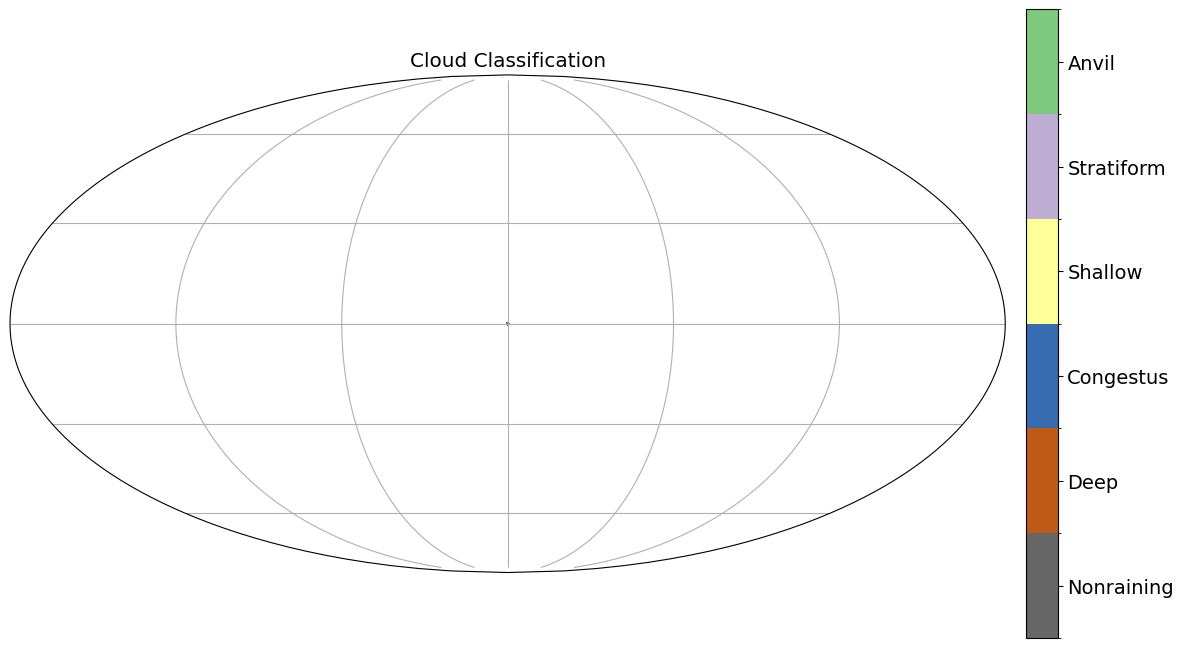

In [12]:
# from matplotlib import colors
# import cartopy.crs as ccrs

# bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)

# nlevs = len(bounds) - 1
# cmap = plt.get_cmap('Accent_r', nlevs)

# fig = plt.figure(figsize=(12,10))
# fig.set_facecolor('white')
# ax = fig.add_subplot(111, projection=ccrs.Mollweide())
# # ax = fig.add_subplot(111)
# ax.gridlines()#draw_labels=True, x_inline=False, y_inline=False)#, dms=True)

# # plt.pcolormesh(xdim, ydim, c_type, cmap=cmap, norm=norm, shading='flat')
# # sc = ax.scatter(lonCell[filter], latCell[filter], c=results[filter], cmap=cmap, norm=norm, s=1)
# sc = ax.scatter(lonCell, latCell, c=results, cmap=cmap, norm=norm, s=1)
# # sc = ax.contourf(lonCell, latCell, c=results, cmap=cmap, norm=norm, s=1)
# # sc = ax.tricontourf(lonCell, latCell, results, levels=15, cmap='viridis')

# cbar=plt.colorbar(sc, fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
# cbar.set_ticklabels(['Nonraining','Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil'])
# cbar.ax.tick_params(labelsize=14)
# ax.set_title("Cloud Classification")
# # plt.xlim(xlim)
# # plt.ylim((-5,25))

# ax.set_global()

# plt.tight_layout()
# # return None